<a href="https://colab.research.google.com/github/suvarnak/Test/blob/master/transformers_doc/en/pytorch/zero_shot_object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Transformers installation
! pip install transformers datasets evaluate accelerate
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


# Zero-shot object detection

Traditionally, models used for [object detection](https://huggingface.co/docs/transformers/main/en/tasks/object_detection) require labeled image datasets for training,
and are limited to detecting the set of classes from the training data.

Zero-shot object detection is a computer vision task to detect objects and their classes in images, without any
prior training or knowledge of the classes. Zero-shot object detection models receive an image as input, as well
as a list of candidate classes, and output the bounding boxes and labels where the objects have been detected.

> [!NOTE]
> Hugging Face houses many such [open vocabulary zero shot object detectors](https://huggingface.co/models?pipeline_tag=zero-shot-object-detection).

In this guide, you will learn how to use such models:
- to detect objects based on text prompts
- for batch object detection
- for image-guided object detection

Before you begin, make sure you have all the necessary libraries installed:

```bash
pip install -q transformers
```

## Zero-shot object detection pipeline

The simplest way to try out inference with models is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a pipeline
for zero-shot object detection from a [checkpoint on the Hugging Face Hub](https://huggingface.co/models?pipeline_tag=zero-shot-object-detection):

In [2]:
from transformers import pipeline

# Use any checkpoint from the hf.co/models?pipeline_tag=zero-shot-object-detection
checkpoint = "iSEE-Laboratory/llmdet_large"
detector = pipeline(model=checkpoint, task="zero-shot-object-detection")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:86: UserWarning: 
Access to the secret `HF_TOKEN` has not been granted on this notebook.
You will not be requested again.
Please restart the session if you want to be prompted again.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


Next, choose an image you'd like to detect objects in. Here we'll use the image of astronaut Eileen Collins that is
a part of the [NASA](https://www.nasa.gov/multimedia/imagegallery/index.html) Great Images dataset.

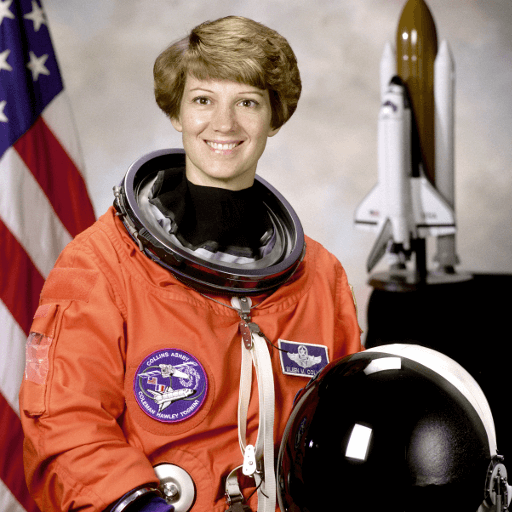

In [3]:
from transformers.image_utils import load_image

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_1.png"
image = load_image(url)
image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_1.png" alt="Astronaut Eileen Collins"/>
</div>

Pass the image and the candidate object labels to look for to the pipeline.
Here we pass the image directly; other suitable options include a local path to an image or an image url. We also pass text descriptions for all items we want to query the image for.

In [4]:
predictions = detector(
    image,
    candidate_labels=["human face", "rocket", "nasa badge", "star-spangled banner"],
    threshold=0.45,
)
predictions

[{'score': 0.8417968153953552,
  'label': 'human face',
  'box': {'xmin': 179, 'ymin': 74, 'xmax': 272, 'ymax': 179}},
 {'score': 0.7375979423522949,
  'label': 'rocket',
  'box': {'xmin': 353, 'ymin': 0, 'xmax': 466, 'ymax': 284}},
 {'score': 0.5848085284233093,
  'label': 'star-spangled banner',
  'box': {'xmin': 0, 'ymin': 0, 'xmax': 96, 'ymax': 511}},
 {'score': 0.569555401802063,
  'label': 'human face',
  'box': {'xmin': 18, 'ymin': 15, 'xmax': 366, 'ymax': 511}},
 {'score': 0.47783660888671875,
  'label': 'star-spangled banner',
  'box': {'xmin': 353, 'ymin': 0, 'xmax': 459, 'ymax': 274}},
 {'score': 0.4664839804172516,
  'label': 'nasa badge',
  'box': {'xmin': 353, 'ymin': 0, 'xmax': 462, 'ymax': 279}},
 {'score': 0.4581947922706604,
  'label': 'nasa badge',
  'box': {'xmin': 132, 'ymin': 348, 'xmax': 208, 'ymax': 423}}]

Let's visualize the predictions:

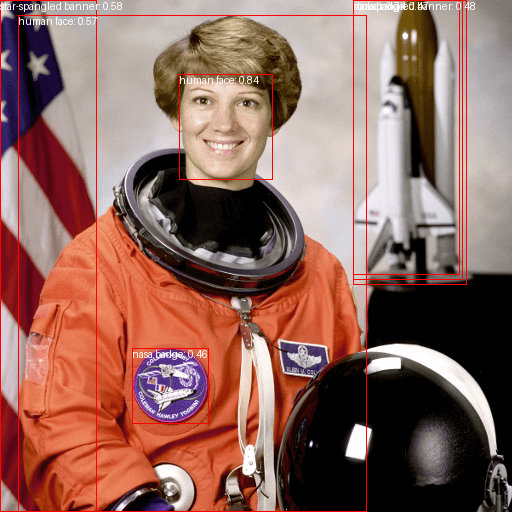

In [5]:
from PIL import ImageDraw

draw = ImageDraw.Draw(image)

for prediction in predictions:
    box = prediction["box"]
    label = prediction["label"]
    score = prediction["score"]

    xmin, ymin, xmax, ymax = box.values()
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{label}: {round(score,2)}", fill="white")

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_2.png" alt="Visualized predictions on NASA image"/>
</div>

## Text-prompted zero-shot object detection by hand

Now that you've seen how to use the zero-shot object detection pipeline, let's replicate the same result manually.

Start by loading the model and associated processor from a [checkpoint on the Hugging Face Hub](https://huggingface.co/docs/transformers/main/en/tasks/hf.co/iSEE-Laboratory/llmdet_large).
Here we'll use the same checkpoint as before:

In [6]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint, device_map="auto")
processor = AutoProcessor.from_pretrained(checkpoint)

Let's take a different image to switch things up.

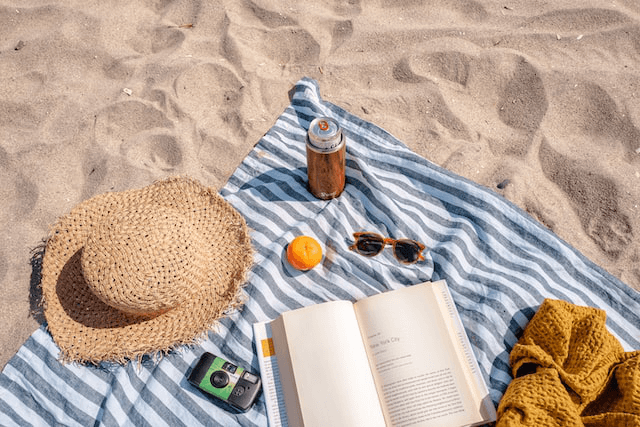

In [7]:
url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png"
image = load_image(url)
image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png" alt="Beach photo"/>
</div>

Use the processor to prepare the inputs for the model.

In [8]:
text_labels = ["hat", "book", "sunglasses", "camera"]
inputs = processor(text=text_labels, images=image, return_tensors="pt")to(model.device)

SyntaxError: invalid syntax (ipython-input-1722664766.py, line 2)

Pass the inputs through the model, post-process, and visualize the results. Since the image processor resized images before
feeding them to the model, you need to use the `post_process_object_detection` method to make sure the predicted bounding
boxes have the correct coordinates relative to the original image:

In [ ]:
import torch

with torch.inference_mode():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
   outputs, threshold=0.50, target_sizes=[(image.height, image.width)], text_labels=text_labels,

In [ ]:
draw = ImageDraw.Draw(image)

scores = results["scores"]
text_labels = results["text_labels"]
boxes = results["boxes"]

for box, score, text_label in zip(boxes, scores, text_labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_label}: {round(score.item(),2)}", fill="white")

image

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_4.png" alt="Beach photo with detected objects"/>
</div>

## Batch processing

You can pass multiple sets of images and text queries to search for different (or same) objects in several images.
Let's use both an astronaut image and the beach image together.
For batch processing, you should pass text queries as a nested list to the processor and images as lists of PIL images,
PyTorch tensors, or NumPy arrays.

In [ ]:
url1 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_1.png"
url2 = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_3.png"
images = [load_image(url1), load_image(url2)]
text_queries = [
    ["human face", "rocket", "nasa badge", "star-spangled banner"],
    ["hat", "book", "sunglasses", "camera", "can"],
]
inputs = processor(text=text_queries, images=images, return_tensors="pt", padding=True)

Previously for post-processing you passed the single image's size as a tensor, but you can also pass a tuple, or, in case
of several images, a list of tuples. Let's create predictions for the two examples, and visualize the second one (`image_idx = 1`).

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

target_sizes = [(image.height, image.width) for image in images]
results = processor.post_process_grounded_object_detection(
    outputs, threshold=0.3, target_sizes=target_sizes, text_labels=text_labels,
)

Let's visualize the results:

In [ ]:
image_idx = 1
draw = ImageDraw.Draw(images[image_idx])

scores = results[image_idx]["scores"].tolist()
text_labels = results[image_idx]["text_labels"]
boxes = results[image_idx]["boxes"].tolist()

for box, score, text_label in zip(boxes, scores, text_labels):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="red", width=1)
    draw.text((xmin, ymin), f"{text_label}: {round(score,2)}", fill="white")

images[image_idx]

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_4.png" alt="Beach photo with detected objects"/>
</div>

## Image-guided object detection

In addition to zero-shot object detection with text queries, models like [OWL-ViT](https://huggingface.co/collections/ariG23498/owlvit-689b0d0872a7634a6ea17ae7) and [OWLv2](https://huggingface.co/collections/ariG23498/owlv2-689b0d27bd7d96ba3c7f7530) offers image-guided object detection. This means you can use an image query to find similar
objects in the target image.

In [ ]:
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

checkpoint = "google/owlv2-base-patch16-ensemble"
model = AutoModelForZeroShotObjectDetection.from_pretrained(checkpoint, device_map="auto")
processor = AutoProcessor.from_pretrained(checkpoint)

Unlike text queries, only a single example image is allowed.

Let's take an image with two cats on a couch as a target image, and an image of a single cat
as a query:

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_target = Image.open(requests.get(url, stream=True).raw)

query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

Let's take a quick look at the images:

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2)
ax[0].imshow(image_target)
ax[1].imshow(query_image)
fig.show()

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_5.png" alt="Cats"/>
</div>

In the preprocessing step, instead of text queries, you now need to use `query_images`:

In [ ]:
inputs = processor(images=image_target, query_images=query_image, return_tensors="pt")

For predictions, instead of passing the inputs to the model, pass them to [image_guided_detection()](https://huggingface.co/docs/transformers/main/en/model_doc/owlvit#transformers.OwlViTForObjectDetection.image_guided_detection). Draw the predictions
as before except now there are no labels.

In [ ]:
with torch.no_grad():
    outputs = model.image_guided_detection(**inputs)
    target_sizes = torch.tensor([image_target.size[::-1]])
    results = processor.post_process_image_guided_detection(outputs=outputs, target_sizes=target_sizes)[0]

draw = ImageDraw.Draw(image_target)

scores = results["scores"].tolist()
boxes = results["boxes"].tolist()

for box, score in zip(boxes, scores):
    xmin, ymin, xmax, ymax = box
    draw.rectangle((xmin, ymin, xmax, ymax), outline="white", width=4)

image_target

<div class="flex justify-center">
     <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/transformers/tasks/zero-sh-obj-detection_6.png" alt="Cats with bounding boxes"/>
</div>